In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_colwidth', None)
import re

In [79]:
#opening file 
file = pd.read_csv('startup_funding.csv')

#rename column City Location had double space
file.rename(columns={'City  Location': 'City Location', 'InvestmentnType' : 'Investment Type'}, inplace=True)

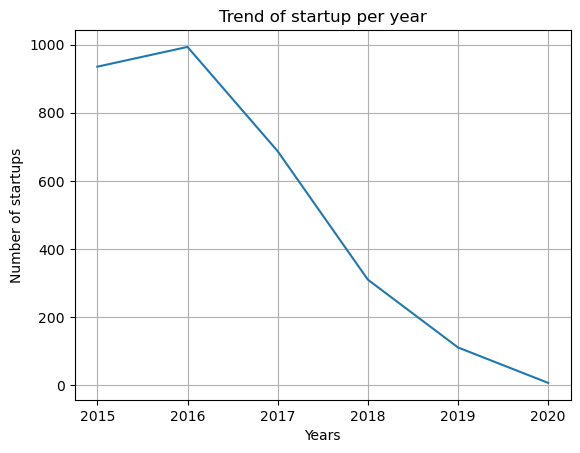

In [94]:
years = pd.Series(file['Date dd/mm/yyyy'].str[-4:])

#cleaning
years  = years[years != '/015']    

#typecasting
years = years.astype('int32')

#preparing data
#returns value count of unique values in descending by default
years_count = years.value_counts()

#plotting
x = years_count.index
y = years_count.values

#using seaborn
sns.lineplot(x = x, y = y)
plt.title('Trend of startup per year')
plt.xlabel('Years')
plt.ylabel('Number of startups')
plt.grid()
plt.show()

#removing series from memory
del years

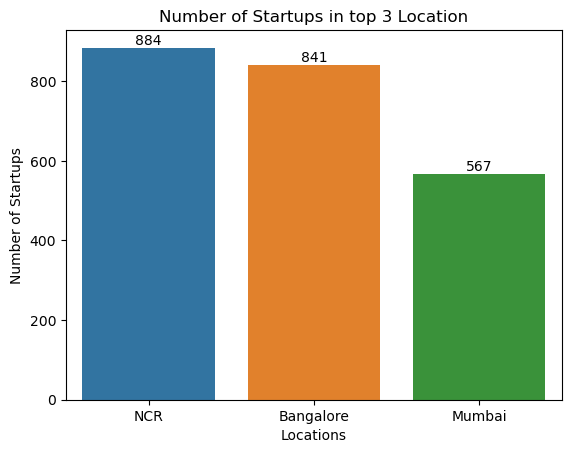

NCR  has maximum number of startups


In [3]:
#Finding location where the most number of funding is done.
#(bw Banglore, Mumbai and NCR only) preferred location.
#NCR include Gurgaon, Noida and New Delhi.

#making a copy
df = file.loc[:, ['City Location', 'Investors Name']].copy()

replacement = {'Bengaluru' : 'Bangalore',
              'Delhi' : 'NCR',
              'New Delhi' : 'NCR',
              'Gurgaon' : 'NCR',
              'Gurugram' : 'NCR',
              'Noida' : 'NCR'}


#capitalizing first letter of city location
df['City Location'] = df['City Location'].str.title()

#replacing city names
df['City Location'] = df['City Location'].replace(replacement)

df = df['City Location'].value_counts()[:3]

#plotting
bar = sns.barplot(x = df.index, y = df.values)

#adding values to bars
for i in bar.containers:
    bar.bar_label(i,)
    
plt.xlabel('Locations')
plt.ylabel('Number of Startups')
plt.title("Number of Startups in top 3 Location")
plt.show()

#idxmax return index of maximum value.
print(df.idxmax(), " has maximum number of startups")

del df

Sequoia Capital    72
Accel Partners     68
Kalaari Capital    50
Blume Ventures     49
Saif Partners      49
Name: Investors Name, dtype: int64


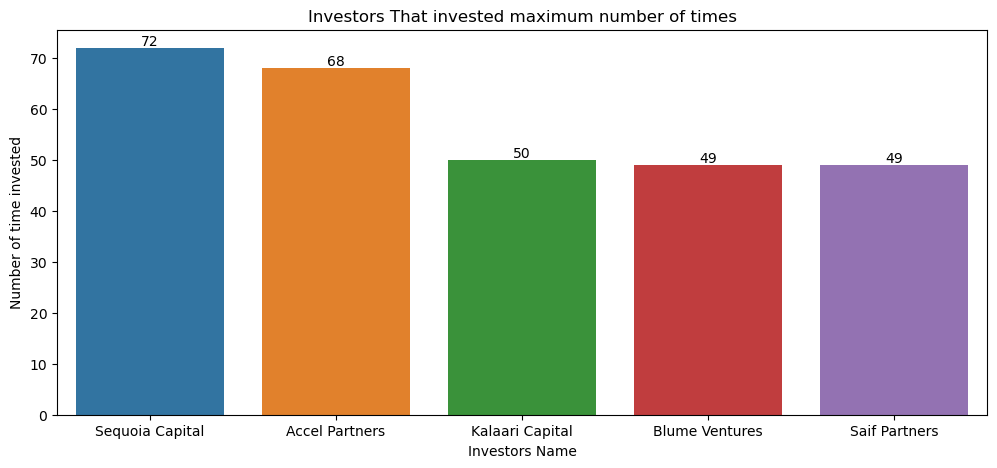

In [15]:
#Finding top 5 investors who have
#invested maximum number of times
#(repeated investment in single company is also included)

#reading file
df = file['Investors Name'].copy()

#cleaning

#explode will make rows for every element on list
#generated by split function
df = df.str.split(',').explode()
#remving white spaces
df = df.str.strip()

#converting '' and 'undisclosed investors 'to Nan value
df = df.replace('', np.nan)
df = df.str.title()
df = df.replace('Undisclosed Investors', np.nan)

#dropping nan value
df.dropna(inplace = True)
df = df.value_counts()[:5]

plt.figure(figsize = (12, 5))
bar = sns.barplot(x = df.index, y = df.values)
plt.title("Investors That invested maximum number of times")
plt.xlabel('Investors Name')
plt.ylabel('Number of time invested')
for i in bar.containers:
    bar.bar_label(i,)

plt.show()
del df

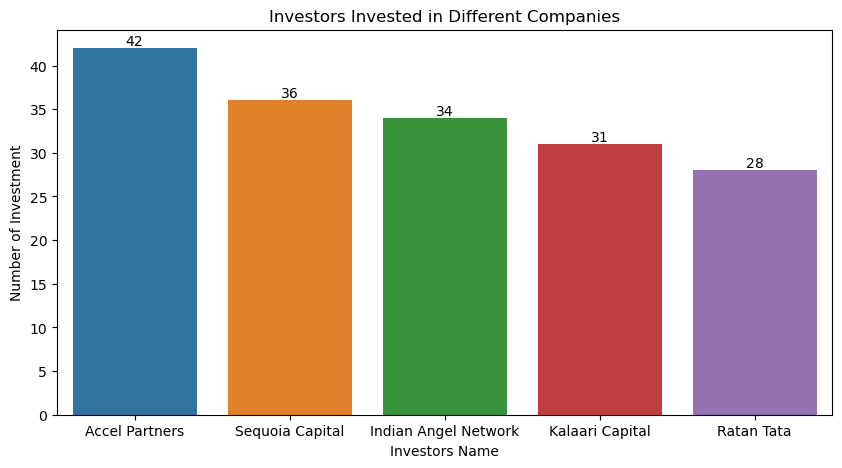

In [87]:
#Finding top 5 Investors who have invested in Different startups

#reading file
df = file[['Investors Name','Startup Name']].copy()

replacement = {'Flipkart.com' : 'Flipkart',
              'Paytm Marketplace' : 'Paytm',
              }
#replacing names of starup to common name
df['Startup Name'] = df['Startup Name'].str.title()
df['Startup Name'] = df['Startup Name'].replace(r'Olacabs|Ola Cabs', 'Ola')
df['Startup Name'] = df['Startup Name'].replace(r'Oyorooms|Oyo Rooms', 'Oyo')
df['Startup Name'] = df['Startup Name'].replace(replacement)

#this will make new column Investors
#investor1 Company1
#investor2 Company2
df = df.assign(Investors=df['Investors Name'].str.split(',')).explode('Investors')
df['Investors'] = df['Investors'].str.title()
#cleaning the data
df['Investors'] = df['Investors'].replace('', np.nan)
df['Investors'] = df['Investors'].replace('Undisclosed Investors', np.nan)
df['Investors'] = df['Investors'].replace('Undisclosed Investor', np.nan)

investor_counts = df.groupby('Investors')['Startup Name'].nunique()
investor_counts = investor_counts.replace('', np.nan)

investor_counts.dropna(inplace = True)
top_investors = investor_counts.sort_values(ascending=False).head(5)

#plotting
plt.figure(figsize = (10,5))
bar = sns.barplot(x = top_investors.index, y= top_investors.values)
for i in bar.containers:
    bar.bar_label(i,)
    
plt.title("Investors Invested in Different Companies")
plt.xlabel("Investors Name")
plt.ylabel('Number of Investment')
plt.show()
del df

In [93]:
#Finding percentage of investments made
#from Seed Funding, Crowd Funding , Debt Funding and Private Equity

df = file[['Investment Type', 'Amount in USD']].copy()
df['Amount in USD'] = df['Amount in USD'].astype(str)
df.dropna(inplace = True)

#df['InvestmentnType'].unique()

replacement = {'Crowd funding' : 'Crowd Funding', 
               'PrivateEquity' : 'Private Equity',
               'SeedFunding' : 'Seed Funding',
               'DebtFunding' : 'Debt Funding'}
#replacing vlaues              }
df['Investment Type'].replace(replacement)

               
#filtering Data              
df = df[(df['Investment Type'] == 'Private Equity') | 
   (df['Investment Type'] == 'Seed Funding') |
  (df['Investment Type'] == 'Crowd Funding') | 
  (df['Investment Type'] == 'Debt Funding')]

df = df[(df['Amount in USD'] != 'undisclosed') & 
       (df['Amount in USD'] != 'Undisclosed') & 
       (df['Amount in USD'] != 'unknown')]

#reseting index 
df.reset_index(drop = True, inplace = True)

               
#same fucnt as discussed above
def clean_pattern(string):
    # Remove unwanted characters or escape sequences
    cleaned_string = re.sub(r"[x\\\\]|(\\\\[a-z0-9]{2})", "", string)
    # Remove commas from the string if needed
    cleaned_string = cleaned_string.replace(",", "")
    return cleaned_string


df['Amount in USD'] = df['Amount in USD'].apply(clean_pattern)

# Convert the 'column_name' to the desired numeric type
df['Amount in USD'] = pd.to_numeric(df['Amount in USD'], errors='coerce')

#grouping by investment type and finding sum
temp = df.groupby(['Investment Type'])['Amount in USD'].sum()

#finding percentage
percentage = (temp.div(temp.sum()) * 100).round(2)
print(percentage.sort_values(ascending = False))

'''
plt.pie(percentage, labels  = percentage.index,autopct='%1.1f%%')
plt.axis('equal')
plt.show()'''
del df

Investment Type
Private Equity    97.37
Seed Funding       2.08
Debt Funding       0.55
Crowd Funding      0.00
Name: Amount in USD, dtype: float64


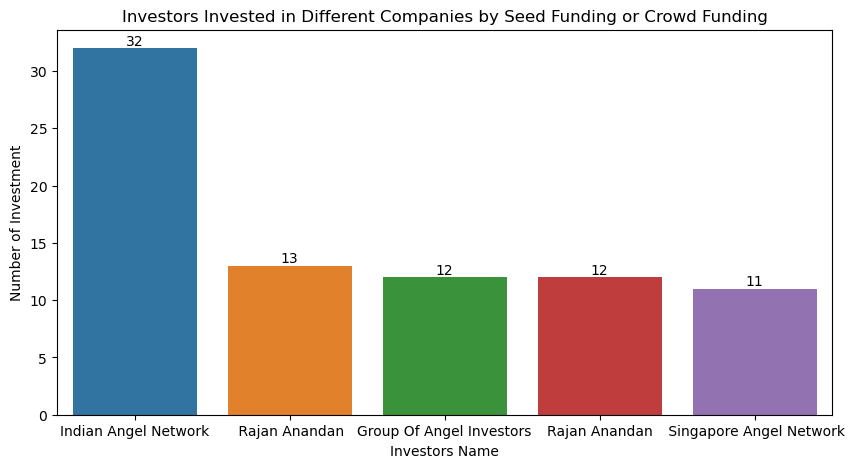

In [88]:
#Finding Top 5 investors who have invested 
#through seed funding or crow funding

df = file[['Investors Name', 'Startup Name', 'Investment Type']].copy()
replacement_investment = {'Crowd funding' : 'Crowd Funding', 
                           'PrivateEquity' : 'Private Equity',
                           'SeedFunding' : 'Seed Funding',
                           'DebtFunding' : 'Debt Funding'}

df['Investment Type'] = df['Investment Type'].str.title()
df['Investment Type'] = df['Investment Type'].replace(replacement_investment)

#filtering by investment Type
df = df[(df['Investment Type'] == 'Seed Funding') |
        (df['Investment Type'] == 'Crowd Funding') ]


replacement = {'Flipkart.com' : 'Flipkart',
              'Paytm Marketplace' : 'Paytm',
              }
#replacing names of starup to common name
df['Startup Name'] = df['Startup Name'].str.title()
df['Startup Name'] = df['Startup Name'].replace(r'Olacabs|Ola Cabs', 'Ola')
df['Startup Name'] = df['Startup Name'].replace(r'Oyorooms|Oyo Rooms', 'Oyo')
df['Startup Name'] = df['Startup Name'].replace(replacement)

#this will make new column Investors
#investor1 Company1
#investor2 Company2
df = df.assign(Investors=df['Investors Name'].str.split(',')).explode('Investors')
df['Investors'] = df['Investors'].str.title()
#cleaning the data
df['Investors'] = df['Investors'].replace('', np.nan)

df['Investors'] = df['Investors'].replace('Undisclosed Investors', np.nan)

df['Investors'] = df['Investors'].replace('Undisclosed Investor', np.nan)
investor_counts = df.groupby('Investors')['Startup Name'].nunique()
investor_counts = investor_counts.replace('', np.nan)

investor_counts.dropna(inplace = True)
top_investors = investor_counts.sort_values(ascending=False).head(5)

#plotting
plt.figure(figsize = (10,5))
bar = sns.barplot(x = top_investors.index, y= top_investors.values)
for i in bar.containers:
    bar.bar_label(i,)
    
plt.title("Investors Invested in Different Companies by Seed Funding or Crowd Funding")
plt.xlabel("Investors Name")
plt.ylabel('Number of Investment')
plt.show()

del df

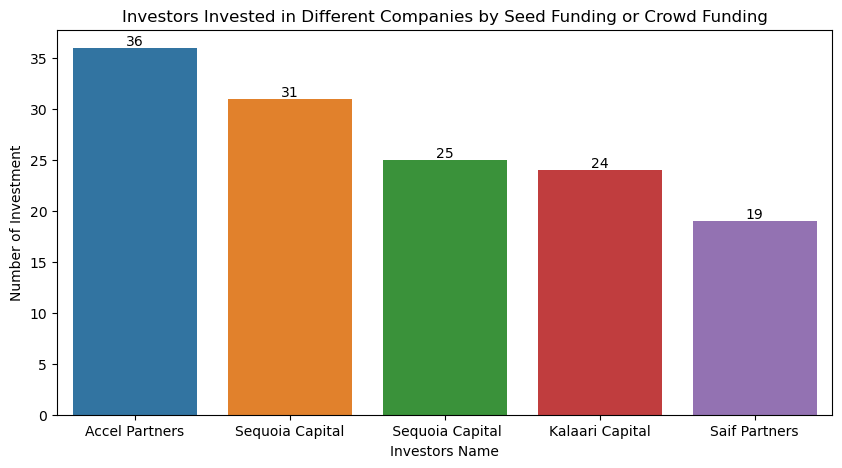

In [89]:
#finding Investors who have invested in 
#different companies by Private Equity

#the above code is used as same (almost)

df = file[['Investors Name', 'Startup Name', 'Investment Type']].copy()
replacement_investment = {'Crowd funding' : 'Crowd Funding', 
                           'PrivateEquity' : 'Private Equity',
                           'SeedFunding' : 'Seed Funding',
                           'DebtFunding' : 'Debt Funding'}

df['Investment Type'] = df['Investment Type'].str.title()
df['Investment Type'] = df['Investment Type'].replace(replacement_investment)

#filtering by investment Type
df = df[(df['Investment Type'] == 'Private Equity')]


replacement = {'Flipkart.com' : 'Flipkart',
              'Paytm Marketplace' : 'Paytm',
              }
#replacing names of starup to common name
df['Startup Name'] = df['Startup Name'].str.title()
df['Startup Name'] = df['Startup Name'].replace(r'Olacabs|Ola Cabs', 'Ola')
df['Startup Name'] = df['Startup Name'].replace(r'Oyorooms|Oyo Rooms', 'Oyo')
df['Startup Name'] = df['Startup Name'].replace(replacement)

#this will make new column Investors
#investor1 Company1
#investor2 Company2
df = df.assign(Investors=df['Investors Name'].str.split(',')).explode('Investors')
df['Investors'] = df['Investors'].str.title()
#cleaning the data
df['Investors'] = df['Investors'].replace('', np.nan)

df['Investors'] = df['Investors'].replace('Undisclosed Investors', np.nan)

df['Investors'] = df['Investors'].replace('Undisclosed Investor', np.nan)
investor_counts = df.groupby('Investors')['Startup Name'].nunique()
investor_counts = investor_counts.replace('', np.nan)

investor_counts.dropna(inplace = True)
top_investors = investor_counts.sort_values(ascending=False).head(5)

#plotting
plt.figure(figsize = (10,5))
bar = sns.barplot(x = top_investors.index, y= top_investors.values)
for i in bar.containers:
    bar.bar_label(i,)
    
plt.title("Investors Invested in Different Companies by Seed Funding or Crowd Funding")
plt.xlabel("Investors Name")
plt.ylabel('Number of Investment')
plt.show()

del df